In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Finding Structural Simiarity
Created on Sun Sep 12 23:47:57 2021

@author: Junho John Song
"""

from tqdm import tqdm

import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import torch

from skimage.metrics import structural_similarity as ssim

In [4]:
adda = sc.read_h5ad('smaller_dada.h5ad')

In [5]:
gene_names = adda.var.index.tolist()
row_col = adda.obs[['array_row', 'array_col']].values.astype(int)
df = pd.DataFrame(data=np.concatenate((row_col, adda.X), axis=1), columns=['row', 'col'] + gene_names)
df['row'] = df['row'].astype(int)
df['col'] = df['col'].astype(int)

In [6]:
def min_max_scale(gm):
    not_nan_values = gm[~np.isnan(gm)]
    mx = not_nan_values.max()
    mn = not_nan_values.min()
    gm = gm - mn
    gm = gm / (mx - mn)
    return gm

def make_gene_map(gene_df, gene_name):
    gm = min_max_scale(gene_df.pivot('row', 'col', gene_name).values)
    gm[np.isnan(gm)] = 0
    return gm

row_len = row_col[:, 0].max() - row_col[:, 0].min() + 1
col_len = row_col[:, 1].max() - row_col[:, 1].min() + 1
gene_maps = np.zeros([len(gene_names), row_len, col_len], dtype=np.float32)
for i, name in enumerate(gene_names):
    gene_maps[i] = make_gene_map(df, name)

In [10]:
def find_similar_genes(target_feat, all_features, top_k=10):
    dist = [-1 * ssim(target_feat, all_features[i]) for i in range(all_features.shape[0])]
    top_k_idx = np.argsort(dist)[1:top_k+1]
    return top_k_idx

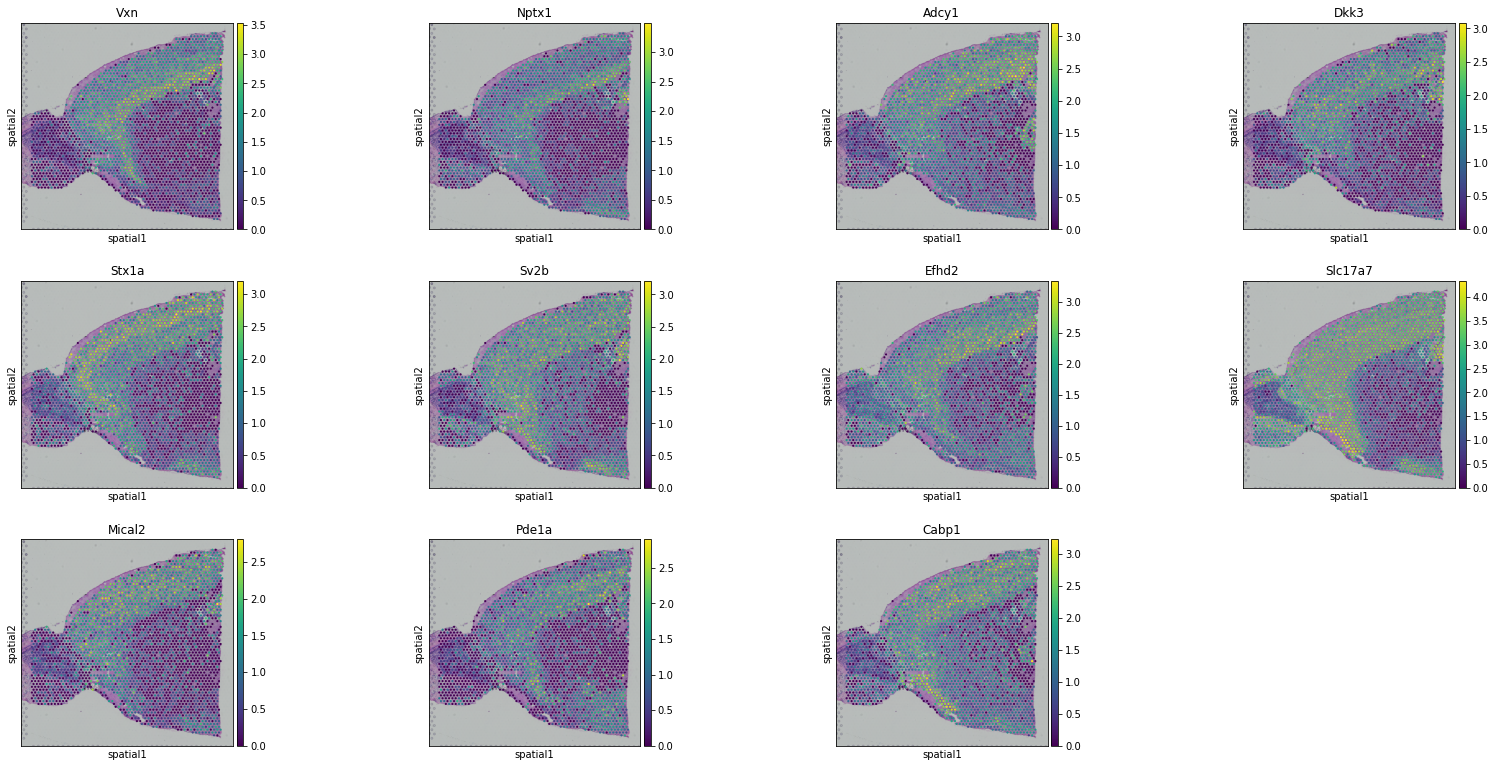

In [11]:
target_gene_name = 'Vxn'
target_gene_idx = gene_names.index(target_gene_name)
top10_genes = find_similar_genes(gene_maps[target_gene_idx], gene_maps)

sc.pl.spatial(adda, color=[target_gene_name] + [gene_names[i] for i in top10_genes])

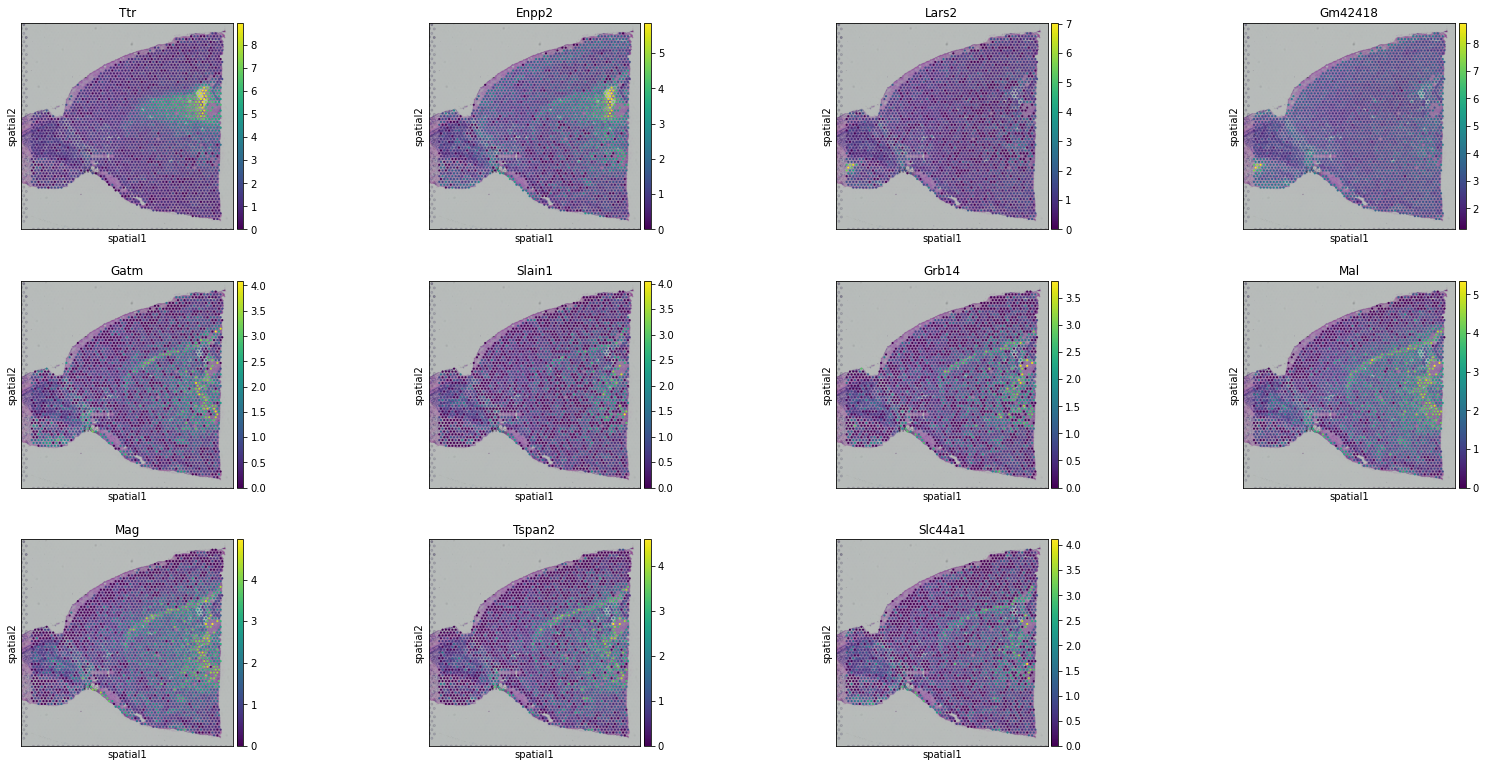

In [13]:
target_gene_name = 'Ttr'
target_gene_idx = gene_names.index(target_gene_name)
top10_genes = find_similar_genes(gene_maps[target_gene_idx], gene_maps)

sc.pl.spatial(adda, color=[target_gene_name] + [gene_names[i] for i in top10_genes])

In [ ]:
## Jaccard & Precision measurement
def jaccard_precision_recall(gt, pred, threshold=0.5):
    assert gt.max() <= 1 and gt.min() >= 0
    assert pred.max() <= 1 and pred.min() >= 0
    assert threshold <= 1 and threshold >= 0
    assert gt.shape[0] == pred.shape[0]
    assert gt.shape[1] == pred.shape[1]

    gt = (gt >= threshold)
    pred = (pred >= threshold)
    
    inter = (gt & pred).sum()
    gt_area = gt.sum()
    pred_area = pred.sum()
    union = gt_area + pred_area - inter
    
    if union > 0:
        jaccard = inter / union
    else:
        jaccard = 0
    if pred_area > 0:
        precision = inter / pred_area
    else:
        precision = 0

    return jaccard, precision

def jaccard_precision_curve(gt, pred, threshold_num=1000):
    threshold_list = []
    jaccard_list = []
    precision_list = []
    for th in np.linspace(0, 1, threshold_num):
        threshold_list.append(th)
        j, p = jaccard_precision_recall(gt, pred, th)
        jaccard_list.append(j)
        precision_list.append(p)

    return threshold_list, jaccard_list, precision_list





In [ ]:
target_gene_name = 'Vxn'
target_gene_idx = gene_names.index(target_gene_name)
top10_genes, l_values = find_similar_genes(l_model_features[target_gene_idx], l_model_features)
gt = gene_maps[target_gene_idx]
jaccard_auc_list = []
precision_auc_list = []
threshold_num = 1000
jaccard_sum = np.zeros([threshold_num])
precision_sum = np.zeros([threshold_num])


In [ ]:

for i in top10_genes:
    pred = gene_maps[i]
    x, j, p = jaccard_precision_curve(gt, pred, threshold_num)
    jaccard_auc_list.append(metrics.auc(x, j))
    precision_auc_list.append(metrics.auc(x, p))
    
    jaccard_sum += j
    precision_sum += p

    plt.figure()
    plt.plot(x, j)
    plt.plot(x, p)
    plt.plot([0, 1], [1, 0])
    plt.show()


In [ ]:
    
jaccard_mean = jaccard_sum / len(top10_genes)
precision_mean = precision_sum /len(top10_genes)
plt.plot(x, jaccard_mean)
plt.ylim([0, 1])
np.mean(jaccard_auc_list)
plt.plot(x, precision_mean)
plt.ylim([0, 1])
np.mean(precision_auc_list)
